In [1]:
!pip install statsmodels

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
gas_data = pd.DataFrame({
    'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
             'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'Gas_Use': [244, 228, 153, 140, 55, 34, 30, 28, 29, 41, 88, 199,
               230, 245, 247, 135, 34, 33, 27, 26, 28, 39, 86, 188],
})

electricity_data = pd.DataFrame({
    'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
             'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'Electric_Use': [967, 795, 820, 672, 722, 820, 1326, 1262, 1126, 814, 821, 918,
                     950, 878, 785, 690, 794, 802, 1445, 1357, 1268, 889, 830, 935],
})

month_number = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

gas_data['Month'] = gas_data['Month'].map(month_number)
electricity_data['Month'] = electricity_data['Month'].map(month_number)

<Axes: >

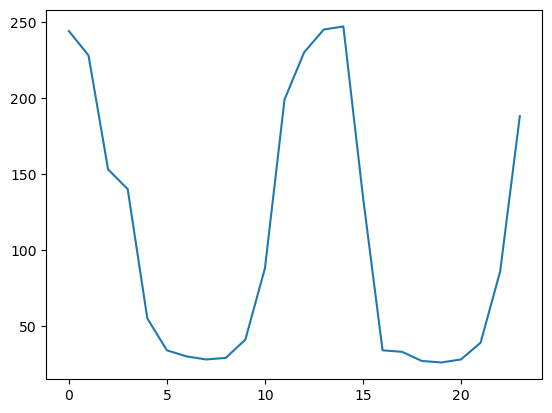

In [4]:
gas_data.Gas_Use.plot()

<Axes: >

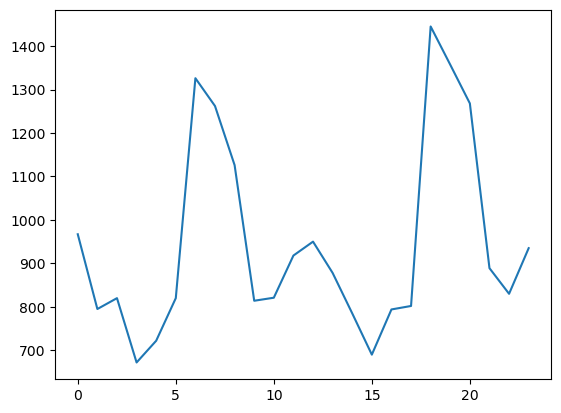

In [5]:
electricity_data.Electric_Use.plot()

# ARIMA

# Áp dụng ARIMA vào Gas

In [6]:
#Kiểm tra xem gas có stationary không
adf_result = adfuller(gas_data['Gas_Use'].dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: 2.2527691187907215
p-value: 0.9989231893156629


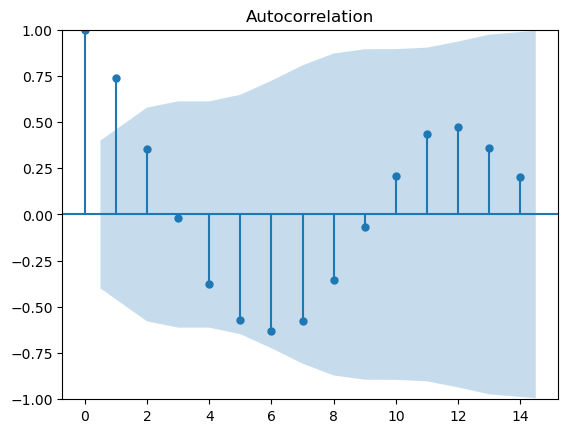

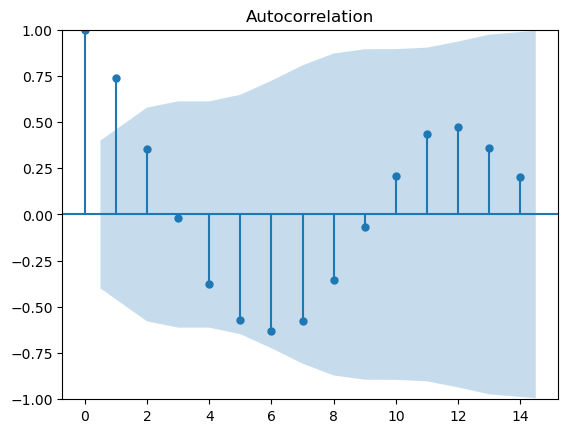

In [7]:
plot_acf(gas_data.Gas_Use)

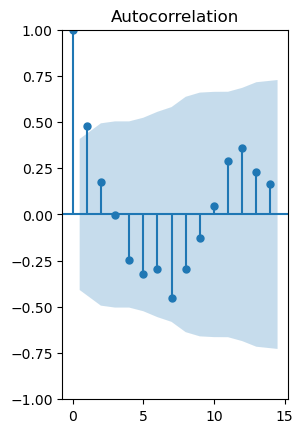

<Axes: >

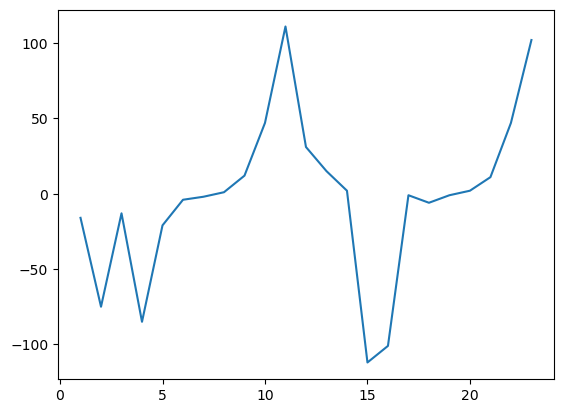

In [8]:
#Lan 1
f = plt.figure()
ax1 = f.add_subplot(122)
plot_acf(gas_data.Gas_Use.diff().dropna(), ax=ax1)
plt.show()
gas_data.Gas_Use.diff().plot()

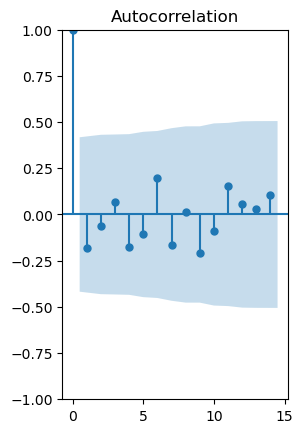

<Axes: >

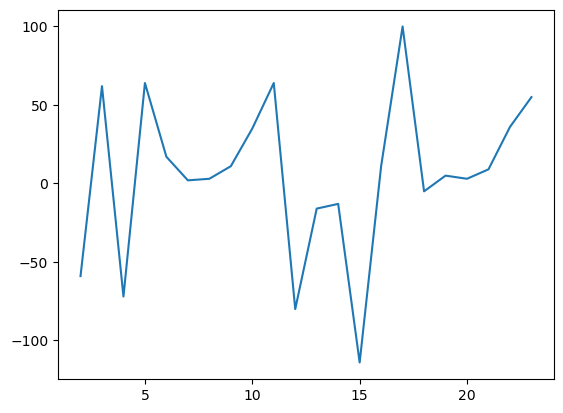

In [9]:
#Lan 2
f = plt.figure()
ax1 = f.add_subplot(122)
plot_acf(gas_data.Gas_Use.diff().diff().dropna(), ax=ax1)
plt.show()
gas_data.Gas_Use.diff().diff().plot()

In [10]:
adf_result = adfuller(gas_data['Gas_Use'].dropna())
print("p-value:", adf_result[1])

adf_result = adfuller(gas_data.Gas_Use.diff().dropna())
print("p-value:", adf_result[1])

adf_result = adfuller(gas_data['Gas_Use'].diff().diff().dropna())
print("p-value:", adf_result[1])

p-value: 0.9989231893156629
p-value: 0.9980976571947952
p-value: 3.948536965191862e-09


Dựa vào p-value, ta thấy kết quả sao hai lần xử lý đã cho kết kết quả nhỏ hơn 0.05 vào khoảng chấp nhận, nên giá trị d có thể xem như bằng 2 (d = 2)

Nhìn vào biểu đồ ACF, ta có thể tìm giá q dựa vào lag có giá trị có thay đổi lớn nhất so với lag kế tiếp. Ta có thể ở cả hai biểu đồ, không có giá trị lag nào vựa qua ngưỡng  => Giá trị q = 0

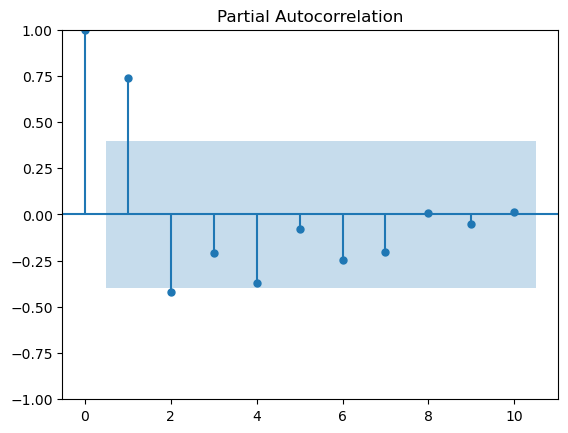

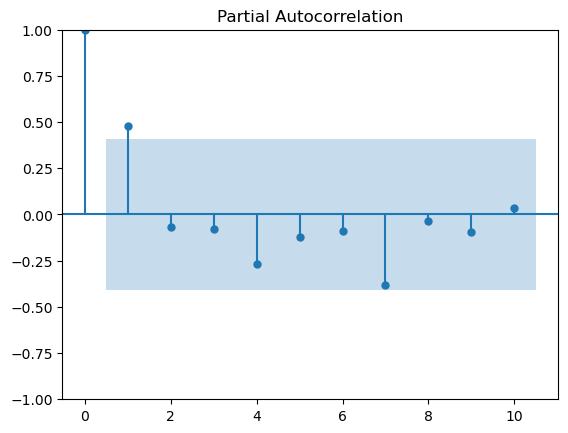

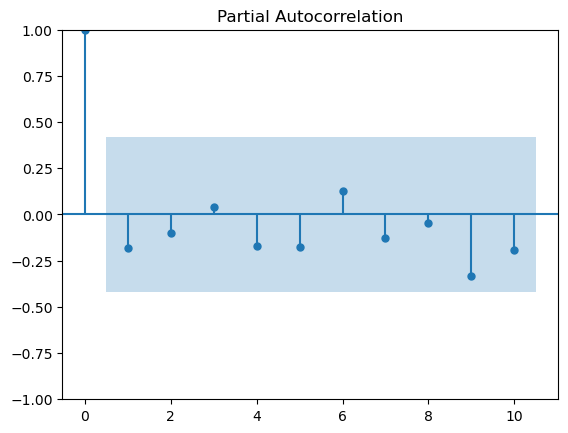

In [34]:
plot_pacf(gas_data.Gas_Use.dropna(), lags = 10)
plt.show()

plot_pacf(gas_data.Gas_Use.diff().dropna(), lags = 10)
plt.show()

plot_pacf(gas_data.Gas_Use.diff().diff().dropna(), lags = 10)
plt.show()

Dựa vào đồ thị ta có thể thấy từ lag 1 trở đi không có lag nào vượt qua ngưỡng và chỉ có lag 1 có giá trị, vì vậy ta có thể xem giá trị p = 1.
Ta có bộ ba giá trị cho model ARIMA là (1, 2, 0)

In [55]:
from statsmodels.tsa.arima.model import ARIMA
train_data = gas_data[:int(0.8*len(gas_data))]
test_data = gas_data[int(0.8*len(gas_data)):]

model = ARIMA(train_data.Gas_Use, order=(1, 2, 0))
fitted_model = model.fit()
print(fitted_model.summary())
print(fitted_model.params)

                               SARIMAX Results                                
Dep. Variable:                Gas_Use   No. Observations:                   19
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 -91.952
Date:                Mon, 29 Apr 2024   AIC                            187.904
Time:                        15:20:29   BIC                            189.570
Sample:                             0   HQIC                           188.070
                                 - 19                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2256      0.330     -0.684      0.494      -0.872       0.421
sigma2      2911.8441   1105.672      2.634      0.008     744.766    5078.922
Ljung-Box (L1) (Q):                   0.02   Jarque-

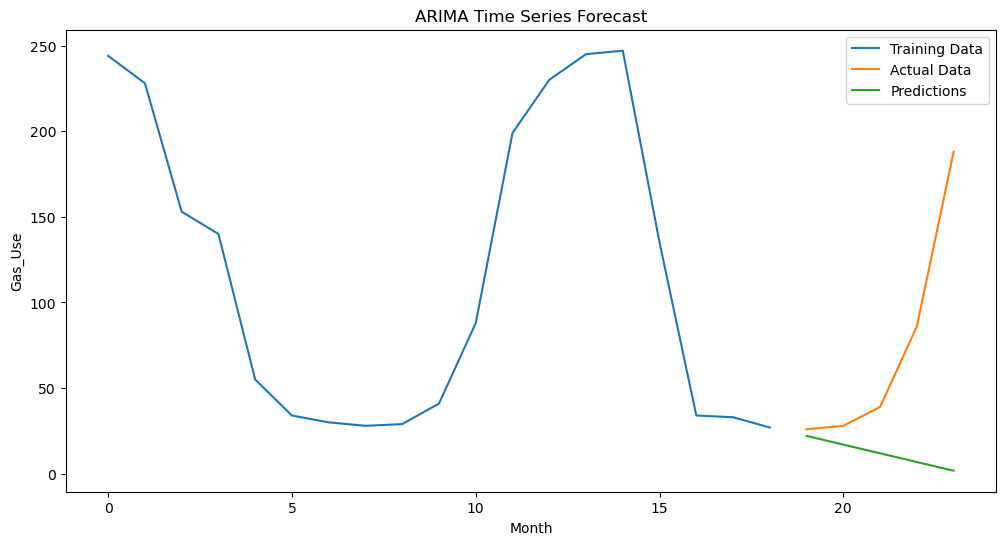

In [56]:
predictions = fitted_model.forecast(steps=len(test_data.Gas_Use))

plt.figure(figsize=(12, 6))
plt.plot(train_data.Gas_Use, label='Training Data')
plt.plot(test_data.index, test_data.Gas_Use, label='Actual Data')
plt.plot(test_data.index, predictions, label='Predictions')
plt.title('ARIMA Time Series Forecast')
plt.xlabel('Month')
plt.ylabel('Gas_Use')
plt.legend()
plt.show()

In [50]:
comparison_df = pd.concat([test_data.Gas_Use, predictions], axis=1)
comparison_df.columns = ['Actual', 'Predicted']

print(comparison_df)

    Actual  Predicted
19      26  18.225275
20      28   7.986737
21      39  -3.024039
22      86 -14.442211
23     188 -26.075306


In [63]:
model = SARIMAX(train_data.Gas_Use, order=(0, 2, 0), seasonal_order=(0, 2, 0, 12))
results = model.fit()

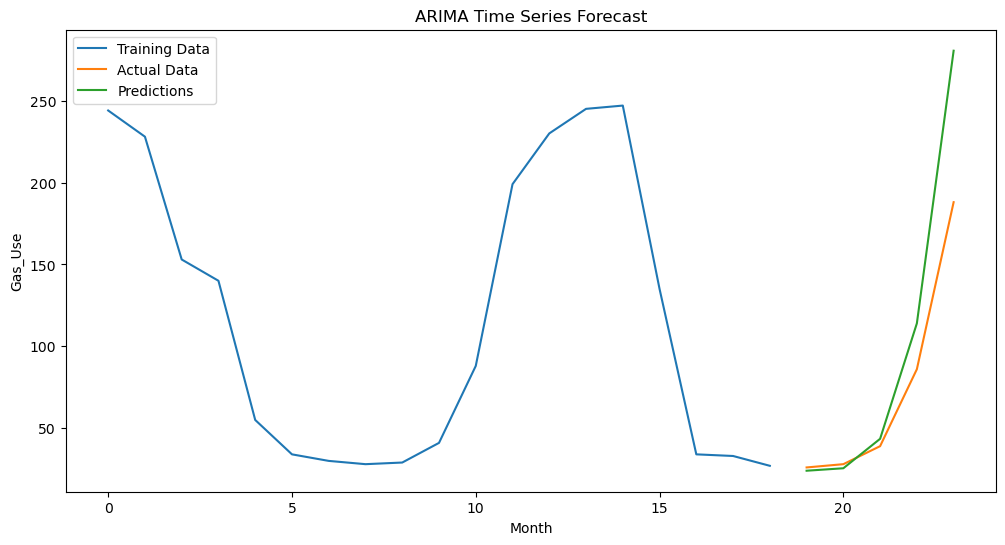

In [40]:
predictions = results.forecast(steps=len(test_data.Gas_Use))

plt.figure(figsize=(12, 6)) 
plt.plot(train_data.Gas_Use, label='Training Data')
plt.plot(test_data.index, test_data.Gas_Use, label='Actual Data')
plt.plot(test_data.index, predictions, label='Predictions')
plt.title('ARIMA Time Series Forecast')
plt.xlabel('Month')
plt.ylabel('Gas_Use')
plt.legend()
plt.show()

In [17]:
comparison_df = pd.concat([test_data.Gas_Use, predictions], axis=1)
comparison_df.columns = ['Actual', 'Predicted']

print(comparison_df)

    Actual  Predicted
19      26       24.0
20      28       25.5
21      39       43.5
22      86      114.0
23     188      280.5


# Áp dụng ARIMA vào Electricity

In [18]:
adf_result = adfuller(electricity_data['Electric_Use'].dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -3.5932336254285753
p-value: 0.005891711725086486


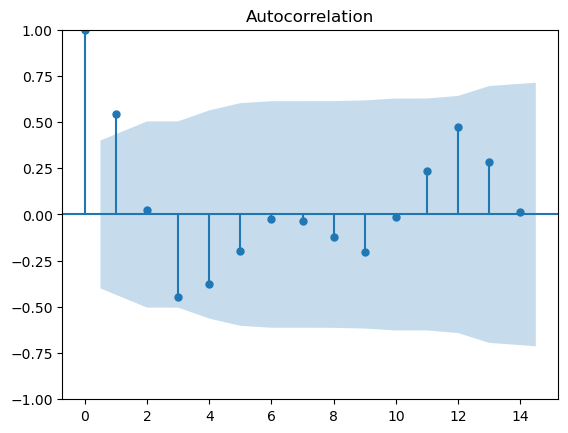

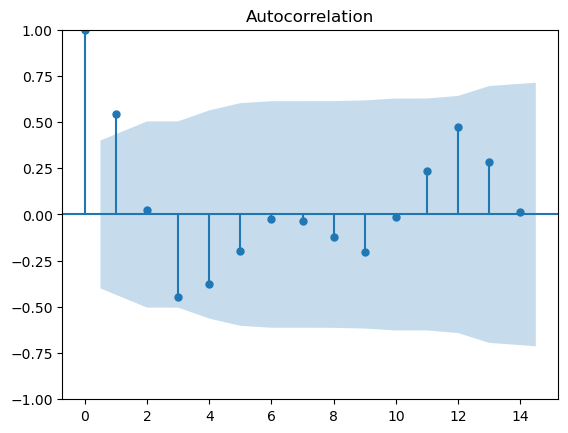

In [19]:
plot_acf(electricity_data.Electric_Use)

p-value < 0.05 nên dataset đã stationary sãn không cần differencing, giá trị d của model = 0.

Dựa vào độ thị ACF, ta thấy có lag 1 có giá trị vượt qua ngưỡng tại lag 1 và không có giá trị lag nào như vậy về sau => q = 1


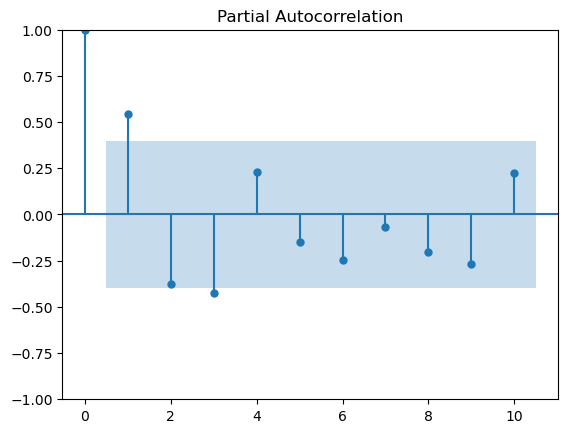

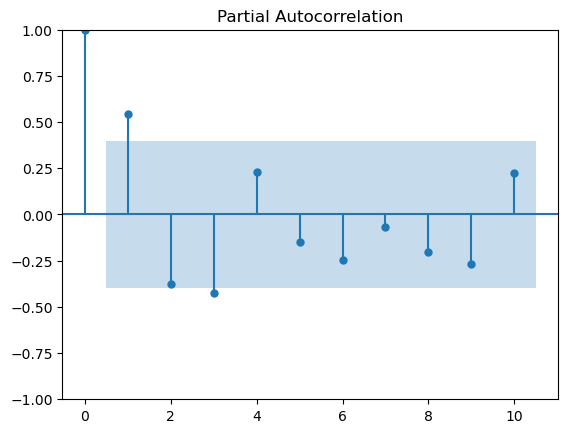

In [20]:
plot_pacf(electricity_data.Electric_Use.dropna(), lags = 10)

Dựa vào biểu đồ PACF, ta thấy lag 1 có trị giá ngoài ngưỡng và chỉ có lag 3 sau đố có giá trị ngoài ngưỡng => p = 1

Từ đó ta có bộ dữ liệu (1,0,1) cho model ARIMA.

In [21]:
train_data = electricity_data[:int(0.8*len(electricity_data))]
test_data = electricity_data[int(0.8*len(electricity_data)):]

model = ARIMA(train_data.Electric_Use, order=(1, 0, 1))
fitted_model = model.fit()
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:           Electric_Use   No. Observations:                   19
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -127.056
Date:                Mon, 29 Apr 2024   AIC                            262.113
Time:                        10:35:31   BIC                            265.890
Sample:                             0   HQIC                           262.752
                                 - 19                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        941.0849    145.536      6.466      0.000     655.839    1226.330
ar.L1          0.2979      1.198      0.249      0.804      -2.050       2.646
ma.L1          0.2618      1.393      0.188      0.8

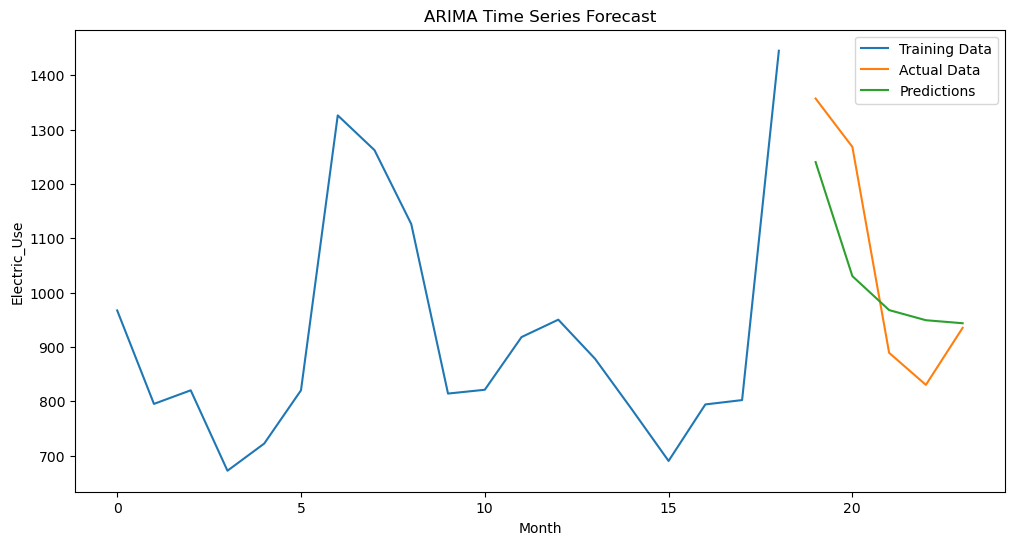

In [22]:
predictions = fitted_model.forecast(steps=len(test_data.Electric_Use))

plt.figure(figsize=(12, 6))
plt.plot(train_data.Electric_Use, label='Training Data')
plt.plot(test_data.index, test_data.Electric_Use, label='Actual Data')
plt.plot(test_data.index, predictions, label='Predictions')
plt.title('ARIMA Time Series Forecast')
plt.xlabel('Month')
plt.ylabel('Electric_Use')
plt.legend()
plt.show()

In [23]:
comparison_df = pd.concat([test_data.Electric_Use, predictions], axis=1)
comparison_df.columns = ['Actual', 'Predicted']

print(comparison_df)

    Actual    Predicted
19    1357  1240.046137
20    1268  1030.158134
21     889   967.623571
22     830   948.991865
23     935   943.440688


In [24]:
model = SARIMAX(train_data.Electric_Use, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
results = model.fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


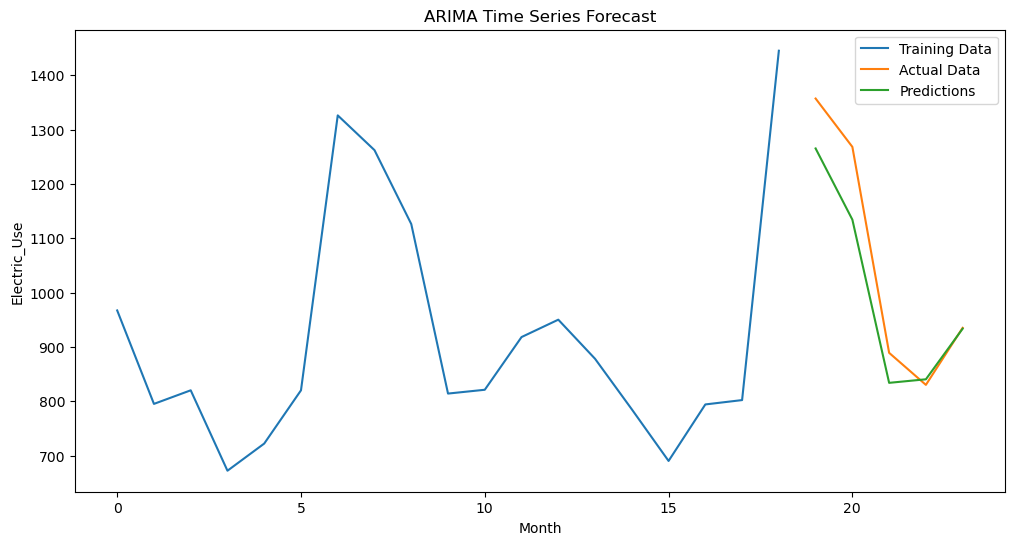

In [25]:
predictions = results.forecast(steps=len(test_data.Electric_Use))

plt.figure(figsize=(12, 6))
plt.plot(train_data.Electric_Use, label='Training Data')
plt.plot(test_data.index, test_data.Electric_Use, label='Actual Data')
plt.plot(test_data.index, predictions, label='Predictions')
plt.title('ARIMA Time Series Forecast')
plt.xlabel('Month')
plt.ylabel('Electric_Use')
plt.legend()
plt.show()

In [26]:
comparison_df = pd.concat([test_data.Electric_Use, predictions], axis=1)
comparison_df.columns = ['Actual', 'Predicted']

print(comparison_df)

    Actual    Predicted
19    1357  1265.117184
20    1268  1134.087166
21     889   833.744593
22     830   840.282751
23     935   933.402116


# SES (Simple Exponential Smoothing)

In [27]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [28]:
train_data = gas_data[:int(0.8*len(gas_data))]
test_data = gas_data[int(0.8*len(gas_data)):]

model = SimpleExpSmoothing(train_data.Gas_Use)
model_fit = model.fit(smoothing_level = 0.2, optimized = False)

predictions = model_fit.forecast(len(test_data.Gas_Use))

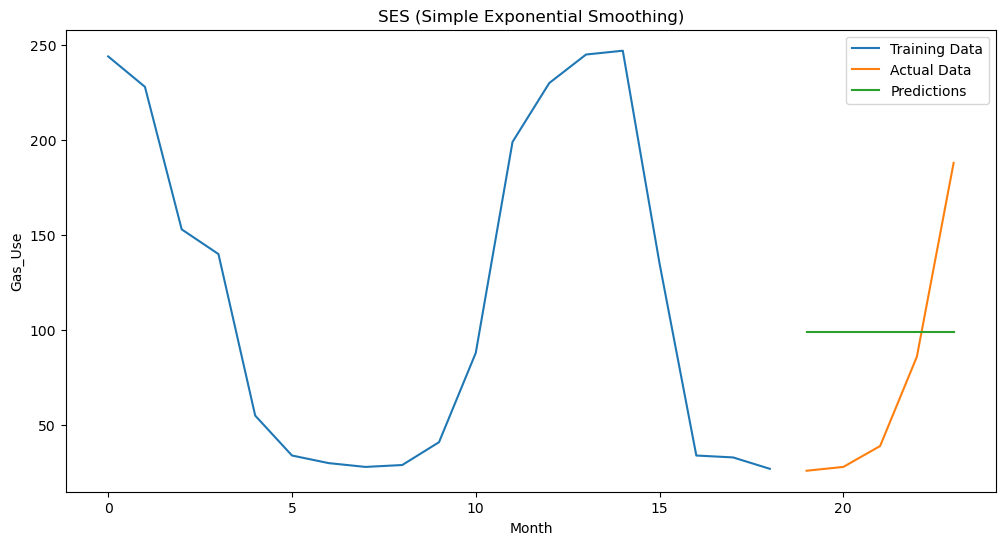

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.Gas_Use, label='Training Data')
plt.plot(test_data.index, test_data.Gas_Use, label='Actual Data')
plt.plot(test_data.index, predictions, label='Predictions')
plt.title('SES (Simple Exponential Smoothing)')
plt.xlabel('Month')
plt.ylabel('Gas_Use')
plt.legend()
plt.show()

In [30]:
comparison_df = pd.concat([test_data.Gas_Use, predictions], axis=1)
comparison_df.columns = ['Actual', 'Predicted']

print(comparison_df)

    Actual  Predicted
19      26  99.247777
20      28  99.247777
21      39  99.247777
22      86  99.247777
23     188  99.247777


In [31]:
train_data = electricity_data[:int(0.8*len(electricity_data))]
test_data = electricity_data[int(0.8*len(electricity_data)):]

model = SimpleExpSmoothing(train_data.Electric_Use)
model_fit = model.fit(smoothing_level = 0.2, optimized = False)

predictions = model_fit.forecast(len(test_data.Electric_Use))

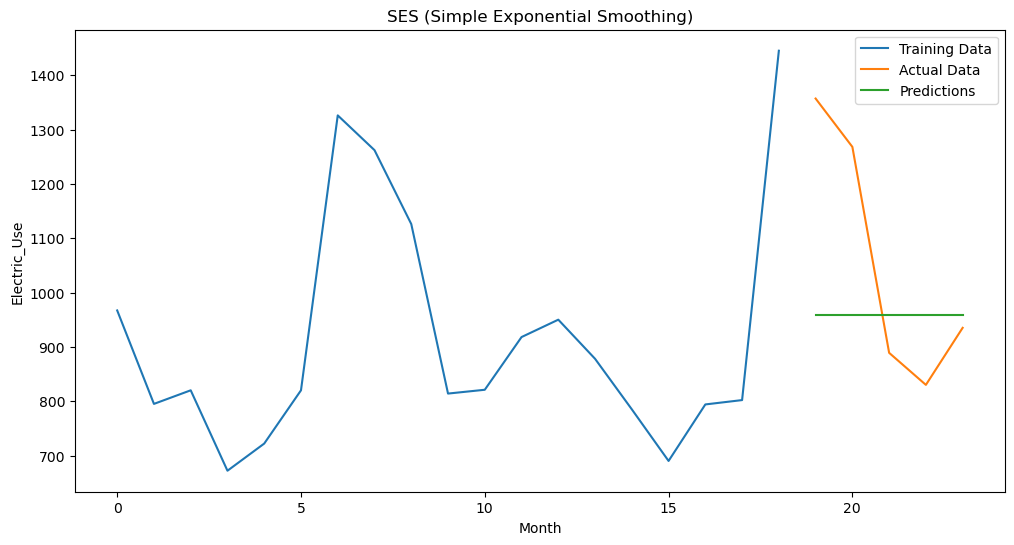

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.Electric_Use, label='Training Data')
plt.plot(test_data.index, test_data.Electric_Use, label='Actual Data')
plt.plot(test_data.index, predictions, label='Predictions')
plt.title('SES (Simple Exponential Smoothing)')
plt.xlabel('Month')
plt.ylabel('Electric_Use')
plt.legend()
plt.show()

In [33]:
comparison_df = pd.concat([test_data.Electric_Use, predictions], axis=1)
comparison_df.columns = ['Actual', 'Predicted']

print(comparison_df)

    Actual   Predicted
19    1357  958.963808
20    1268  958.963808
21     889  958.963808
22     830  958.963808
23     935  958.963808
